## Packages

In [1]:
import pandas as pd
import numpy as np
import os,sys
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sparse

import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture

/Users/leilasapple/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/Users/leilasapple/.matplotlib/matplotlibrc", line #621
  (fname, cnt))
/Users/leilasapple/anaconda/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


## Paths

In [2]:
#The input directory in the google dirve
input_data_path="../Fromgoogle/Input_files"
os.listdir(input_data_path+'/produced')

['.ipynb_checkpoints',
 'data_InstaCart.csv',
 'data_InstaCart_rating.csv',
 'data_InstaCart_sparse.npz',
 'data_InstaCart_sparse_2.npz',
 'dprt_class_GMM.csv',
 'dprt_user_GMM_class.csv']

## Input files

In [3]:
df=pd.read_csv(os.path.join(input_data_path+'/produced','data_InstaCart.csv')).loc[:,['user_id','department_id']]

In [4]:
df.head()

,user_id,department_id
0,1,7.0
1,1,19.0
2,1,16.0
3,1,19.0
4,1,17.0


In [5]:
print('Number of users:\t',df.user_id.nunique(),'\nNumber of departments:\t',df.department_id.nunique())

Number of users:	 206209 
Number of departments:	 21


## Processing data

In [6]:
df=df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 33894105
Data columns (total 2 columns):
user_id          int64
department_id    float64
dtypes: float64(1), int64(1)
memory usage: 774.1 MB


In [8]:
df.isnull().sum()

user_id          0
department_id    0
dtype: int64

## Calculating rates 

In [9]:
df=df.join(pd.DataFrame({'dprt_prod_num':df.groupby(['user_id','department_id']).size()}).reset_index().set_index(['user_id','department_id']),
       on=(['user_id','department_id']))
df.head(20)

,user_id,department_id,dprt_prod_num
0,1,7.0,15
1,1,19.0,25
2,1,16.0,17
3,1,19.0,25
4,1,17.0,3
5,1,7.0,15
6,1,19.0,25
7,1,19.0,25
8,1,14.0,4
9,1,4.0,5


In [10]:
df=df.join(pd.DataFrame({'quantity':df.groupby('user_id').size()}),on=('user_id'))
df=df.join(pd.DataFrame({'uniq_dprt_num':df.groupby('user_id').department_id.nunique()}),on=('user_id'))
df.head()

,user_id,department_id,dprt_prod_num,quantity,uniq_dprt_num
0,1,7.0,15,70,7
1,1,19.0,25,70,7
2,1,16.0,17,70,7
3,1,19.0,25,70,7
4,1,17.0,3,70,7


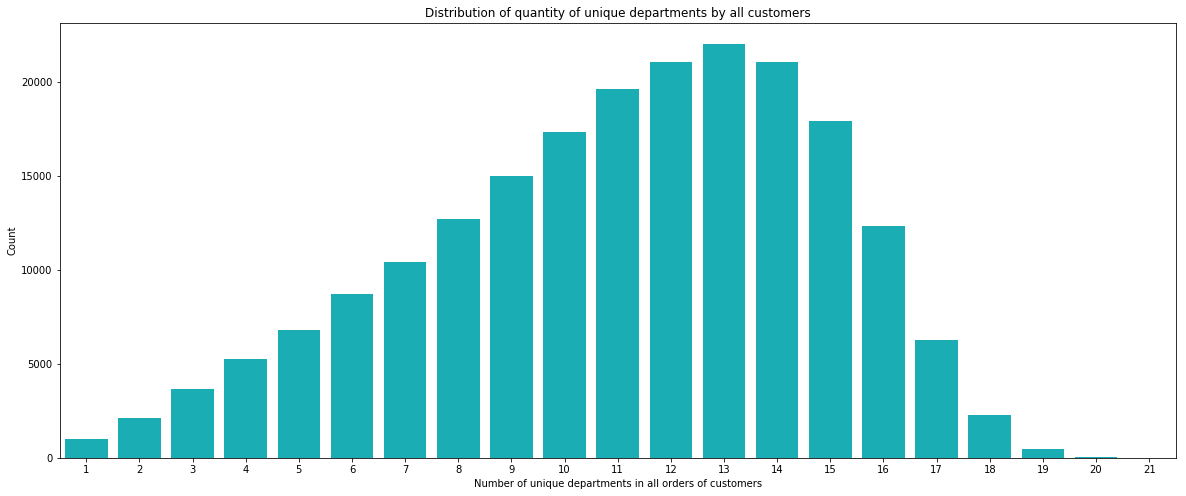

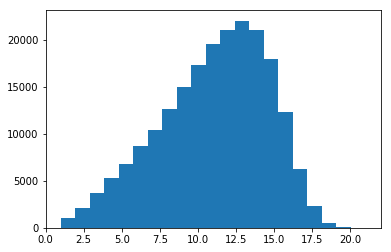

In [11]:
df_=df.loc[:,['user_id','uniq_dprt_num']].drop_duplicates(subset=['user_id'], keep='first')
import seaborn as sns
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20,8))
sns.countplot(x='uniq_dprt_num',data=df_,color='#00C5CD')
#plt.hist(df_.uniq_dprt_num, bins=int(728))
plt.xlabel('Number of unique departments in all orders of customers')
plt.ylabel('Count')
plt.title('Distribution of quantity of unique departments by all customers')
plt.show()
a,b,c=plt.hist(df_.uniq_dprt_num, bins=int(21))
del df_

In [12]:
a.max()

22047.0

In [13]:
a.argmax()

12

In [14]:
df['ratio']=df.dprt_prod_num/df.quantity

In [15]:
df=df.join(pd.DataFrame({'max_ratio':df.groupby('user_id').ratio.max()}).reset_index().set_index('user_id'),on=('user_id'))

In [16]:
df['rate']=100*df.ratio/df.max_ratio

In [17]:
df.head()

,user_id,department_id,dprt_prod_num,quantity,uniq_dprt_num,ratio,max_ratio,rate
0,1,7.0,15,70,7,0.214286,0.357143,60.0
1,1,19.0,25,70,7,0.357143,0.357143,100.0
2,1,16.0,17,70,7,0.242857,0.357143,68.0
3,1,19.0,25,70,7,0.357143,0.357143,100.0
4,1,17.0,3,70,7,0.042857,0.357143,12.0


In [18]:
df=df.drop_duplicates(subset=['user_id', 'department_id'], keep='first')

In [19]:
rows=df.user_id.values
cols=df.department_id.astype(int).values
rating=df.rate.values
dprt_user_rate=sparse.csr_matrix((rating, (rows, cols)), shape=(df.user_id.nunique()+1, df.department_id.nunique()+1)).toarray()


In [20]:
dprt_user_rate=dprt_user_rate[1:,1:]

In [21]:
dprt_user_rate[0:10]

array([[   0.        ,    0.        ,    0.        ,   20.        ,
           0.        ,    0.        ,   60.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           4.        ,   16.        ,    0.        ,   68.        ,
          12.        ,    0.        ,  100.        ,    0.        ,    0.        ],
       [  57.14285714,    0.        ,    4.08163265,   87.75510204,
           0.        ,    6.12244898,   18.36734694,    0.        ,
           0.        ,    0.        ,    4.08163265,    2.04081633,
          22.44897959,    6.12244898,    8.16326531,  100.        ,
           0.        ,    0.        ,   95.91836735,   48.97959184,    0.        ],
       [  15.78947368,    0.        ,    0.        ,  100.        ,
           0.        ,    0.        ,    7.89473684,    0.        ,
          10.52631579,    0.        ,    0.        ,    0.        ,
          10.52631579,    0.        ,    0.        ,   55.26315789,
           2.631

In [22]:
df.loc[df.user_id==1]

,user_id,department_id,dprt_prod_num,quantity,uniq_dprt_num,ratio,max_ratio,rate
0,1,7.0,15,70,7,0.214286,0.357143,60.0
1,1,19.0,25,70,7,0.357143,0.357143,100.0
2,1,16.0,17,70,7,0.242857,0.357143,68.0
4,1,17.0,3,70,7,0.042857,0.357143,12.0
8,1,14.0,4,70,7,0.057143,0.357143,16.0
9,1,4.0,5,70,7,0.071429,0.357143,20.0
15,1,13.0,1,70,7,0.014286,0.357143,4.0


In [ ]:
df.to_csv(os.path.join(input_data_path+'/produced','data_InstaCart_rating_dprt.csv'), encoding='utf-8', index=False)

## Clustering  based on rating department

In [85]:
X=dprt_user_rate

### GMM Clustering

To find the best component for GMM culstering can be assessed out by a code silimar to doing detemining hyper parameters. This code is from [Gaussian Mixture Model Selection](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py) website. Based on the comparision given in [Clustering](http://scikit-learn.org/stable/modules/clustering.html), GMM method has chosen for having less expences. [GMM method](http://scikit-learn.org/stable/modules/mixture.html#mixture) is the general form of Kmean. 

Automatically created module for IPython interactive environment


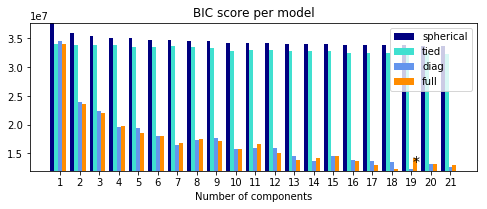

In [88]:
print(__doc__)


# Generate random sample, two components

lowest_bic = np.infty
bic = []
n_components_range = range(1, 22)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)


In [89]:
Y_pred = clf.predict(X)

In [93]:
Y_pred[0:10]

array([ 5, 18,  0,  1,  0,  0, 10,  0, 18,  0])

In [111]:
dprt_rating=pd.DataFrame({'user_id':list(range(df.user_id.nunique()))+np.ones(df.user_id.nunique()).astype(int),
                          'user_dprt_class':Y_pred})

In [112]:
dprt_rating.head()

,user_id,user_dprt_class
0,1,5
1,2,18
2,3,0
3,4,1
4,5,0


## Saving

In [114]:
dprt_rating.to_csv(os.path.join(input_data_path,'dprt_user_GMM_class.csv'))

In [ ]:
np.mean([0.956,0.865,0.864,0.905,0.884,0.916,0.873,0.892,0.84,0.923,0.906,0.947,0.854,0.85,0.938,0.839,0.733,0.92,0.921])